This kernel is inspired by Heng's [discussion](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/106462#latest-618693), which is about [HRNet-Semantic-Segmentation](https://arxiv.org/abs/1904.04514)
![](https://raw.githubusercontent.com/HRNet/HRNet-Semantic-Segmentation/master/figures/seg-hrnet.png?generation=1565963628491533&amp;alt=media)


I played with the architecture of this model and after many trails got it to work in kaggle kernels without needing anykind of dependencies. I made few changes to the original configuration of the model so that the output shape is same as the input's height and width, just like other segmentation architectures. There are six configurations available [here](https://github.com/HRNet/HRNet-Semantic-Segmentation/tree/master/experiments/cityscapes) for cityspacecs dataset; the one used in this kernel is `seg_hrnet_w18_small_v1_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484.yaml`. You can try other configurations as well but to run in the kernel(for submission) you will need to convert the configurations file in `dict` as done in this kernel(or you can try other ways...suggestions are welcome!!!)

In [8]:
# Imports
import os
import logging
import functools
import json
import numpy as np

import torch
import torch.nn as nn
import torch._utils
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pylab as plt
from torch.nn.modules.batchnorm import _BatchNorm
import warnings
warnings.filterwarnings("ignore")

In [144]:
import queue
import collections
import threading
import scipy.io

In [23]:
class SyncMaster(object):
    """An abstract `SyncMaster` object.
    - During the replication, as the data parallel will trigger an callback of each module, all slave devices should
    call `register(id)` and obtain an `SlavePipe` to communicate with the master.
    - During the forward pass, master device invokes `run_master`, all messages from slave devices will be collected,
    and passed to a registered callback.
    - After receiving the messages, the master device should gather the information and determine to message passed
    back to each slave devices.
    """

    def __init__(self, master_callback):
        """
        Args:
            master_callback: a callback to be invoked after having collected messages from slave devices.
        """
        self._master_callback = master_callback
        self._queue = queue.Queue()
        self._registry = collections.OrderedDict()
        self._activated = False

    def register_slave(self, identifier):
        """
        Register an slave device.
        Args:
            identifier: an identifier, usually is the device id.
        Returns: a `SlavePipe` object which can be used to communicate with the master device.
        """
        if self._activated:
            assert self._queue.empty(), 'Queue is not clean before next initialization.'
            self._activated = False
            self._registry.clear()
        future = FutureResult()
        self._registry[identifier] = _MasterRegistry(future)
        return SlavePipe(identifier, self._queue, future)

    def run_master(self, master_msg):
        self._activated = True

        intermediates = [(0, master_msg)]
        for i in range(self.nr_slaves):
            intermediates.append(self._queue.get())

        results = self._master_callback(intermediates)
        assert results[0][0] == 0, 'The first result should belongs to the master.'

        for i, res in results:
            if i == 0:
                continue
            self._registry[i].result.put(res)

        for i in range(self.nr_slaves):
            assert self._queue.get() is True

        return results[0][1]

    @property
    def nr_slaves(self):
        return len(self._registry)

In [24]:
class _SynchronizedBatchNorm(_BatchNorm):
    def __init__(self, num_features, eps=1e-5, momentum=0.001, affine=True):
        super(_SynchronizedBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum, affine=affine)

        self._sync_master = SyncMaster(self._data_parallel_master)

        self._is_parallel = False
        self._parallel_id = None
        self._slave_pipe = None

        # customed batch norm statistics
        self._moving_average_fraction = 1. - momentum
        self.register_buffer('_tmp_running_mean', torch.zeros(self.num_features))
        self.register_buffer('_tmp_running_var', torch.ones(self.num_features))
        self.register_buffer('_running_iter', torch.ones(1))
        self._tmp_running_mean = self.running_mean.clone() * self._running_iter
        self._tmp_running_var = self.running_var.clone() * self._running_iter

    def forward(self, input):
        # If it is not parallel computation or is in evaluation mode, use PyTorch's implementation.
        if not (self._is_parallel and self.training):
            return F.batch_norm(
                input, self.running_mean, self.running_var, self.weight, self.bias,
                self.training, self.momentum, self.eps)

        # Resize the input to (B, C, -1).
        input_shape = input.size()
        input = input.view(input.size(0), self.num_features, -1)

        # Compute the sum and square-sum.
        sum_size = input.size(0) * input.size(2)
        input_sum = _sum_ft(input)
        input_ssum = _sum_ft(input ** 2)

        # Reduce-and-broadcast the statistics.
        if self._parallel_id == 0:
            mean, inv_std = self._sync_master.run_master(_ChildMessage(input_sum, input_ssum, sum_size))
        else:
            mean, inv_std = self._slave_pipe.run_slave(_ChildMessage(input_sum, input_ssum, sum_size))

        # Compute the output.
        if self.affine:
            # MJY:: Fuse the multiplication for speed.
            output = (input - _unsqueeze_ft(mean)) * _unsqueeze_ft(inv_std * self.weight) + _unsqueeze_ft(self.bias)
        else:
            output = (input - _unsqueeze_ft(mean)) * _unsqueeze_ft(inv_std)

        # Reshape it.
        return output.view(input_shape)

    def __data_parallel_replicate__(self, ctx, copy_id):
        self._is_parallel = True
        self._parallel_id = copy_id

        # parallel_id == 0 means master device.
        if self._parallel_id == 0:
            ctx.sync_master = self._sync_master
        else:
            self._slave_pipe = ctx.sync_master.register_slave(copy_id)

    def _data_parallel_master(self, intermediates):
        """Reduce the sum and square-sum, compute the statistics, and broadcast it."""
        intermediates = sorted(intermediates, key=lambda i: i[1].sum.get_device())

        to_reduce = [i[1][:2] for i in intermediates]
        to_reduce = [j for i in to_reduce for j in i]  # flatten
        target_gpus = [i[1].sum.get_device() for i in intermediates]

        sum_size = sum([i[1].sum_size for i in intermediates])
        sum_, ssum = ReduceAddCoalesced.apply(target_gpus[0], 2, *to_reduce)

        mean, inv_std = self._compute_mean_std(sum_, ssum, sum_size)

        broadcasted = Broadcast.apply(target_gpus, mean, inv_std)

        outputs = []
        for i, rec in enumerate(intermediates):
            outputs.append((rec[0], _MasterMessage(*broadcasted[i*2:i*2+2])))

        return outputs

In [25]:
class SynchronizedBatchNorm2d(_SynchronizedBatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'
                             .format(input.dim()))
        super(SynchronizedBatchNorm2d, self)._check_input_dim(input)

In [26]:
BatchNorm2d = SynchronizedBatchNorm2d
BN_MOMENTUM = 0.1

In [29]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [32]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}

In [35]:
class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=True)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=True)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=(height_output, width_output),
                        mode='bilinear',
                        align_corners=False)
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse

In [38]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [109]:
class HRNetV2(nn.Module):
    def __init__(self, **kwargs):
        super(HRNetV2, self).__init__()
        extra = {
            'STAGE2': {'NUM_MODULES': 1, 'NUM_BRANCHES': 2, 'BLOCK': 'BASIC', 'NUM_BLOCKS': (4, 4), 'NUM_CHANNELS': (48, 96), 'FUSE_METHOD': 'SUM'},
            'STAGE3': {'NUM_MODULES': 4, 'NUM_BRANCHES': 3, 'BLOCK': 'BASIC', 'NUM_BLOCKS': (4, 4, 4), 'NUM_CHANNELS': (48, 96, 192), 'FUSE_METHOD': 'SUM'},
            'STAGE4': {'NUM_MODULES': 3, 'NUM_BRANCHES': 4, 'BLOCK': 'BASIC', 'NUM_BLOCKS': (4, 4, 4, 4), 'NUM_CHANNELS': (48, 96, 192, 384), 'FUSE_METHOD': 'SUM'},
            'FINAL_CONV_KERNEL': 1
            }

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(Bottleneck, 64, 64, 4)

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer([256], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(
                    num_branches,
                    block,
                    num_blocks,
                    num_inchannels,
                    num_channels,
                    fuse_method,
                    reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x, return_feature_maps=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.interpolate(
            x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=False)
        x2 = F.interpolate(
            x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=False)
        x3 = F.interpolate(
            x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=False)

        x = torch.cat([x[0], x1, x2, x3], 1)

        # x = self.last_layer(x)
        return [x]
    
    def init_weights(self, pretrained='',):
#         logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if pretrained:
            pretrained_dict = torch.load(pretrained, map_location=torch.device('cpu'))
#             logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
#             for k, _ in pretrained_dict.items():
#                 logger.info(
#                     '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)


def get_encoder(path, **kwargs):
    model = HRNetV2()
    model.init_weights(path)
    return model

In [110]:
def conv3x3_bn_relu(in_planes, out_planes, stride=1):
    "3x3 convolution + BN + relu"
    return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=3,
                      stride=stride, padding=1, bias=False),
            BatchNorm2d(out_planes),
            nn.ReLU(inplace=True),
            )

In [125]:
# last conv
class C1(nn.Module):
    def __init__(self, num_class=150, fc_dim=2048, use_softmax=True):
        super(C1, self).__init__()
        self.use_softmax = use_softmax

        self.cbr = conv3x3_bn_relu(fc_dim, fc_dim // 4, 1)

        # last conv
        self.conv_last = nn.Conv2d(fc_dim // 4, num_class, 1, 1, 0)

    def forward(self, conv_out, segSize=None):
        conv5 = conv_out[-1]
        x = self.cbr(conv5)
        x = self.conv_last(x)

        if self.use_softmax: # is True during inference
            x = nn.functional.interpolate(
                x, size=segSize, mode='bilinear', align_corners=False)
            x = nn.functional.softmax(x, dim=1)
        else:
            x = nn.functional.log_softmax(x, dim=1)

        return x
    
    def init_weights(self, pretrained='',):
#         logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if pretrained:
            pretrained_dict = torch.load(pretrained, map_location=torch.device('cpu'))
#             logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
#             for k, _ in pretrained_dict.items():
#                 logger.info(
#                     '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

            
def get_decoder(n_class, path):
    model = C1(num_class=n_class, fc_dim=720)
    model.init_weights(path)
    return model

In [112]:
with open('params.json', 'r') as file:
    params = json.load(file)

In [127]:
# encoder = get_seg_model(params)
encoder = get_encoder('encoder_epoch_30.pth')
# encoder = get_encoder('hrnetv2_w48-imagenet.pth')

In [128]:
decoder = get_decoder(150, 'decoder_epoch_30.pth')

In [129]:
# model = nn.Sequential(encoder, decoder)

I tried to train using the architecture in kaggle kernels but got `RunTimeError`. Maybe decreasing `batch_size` would work but I didn't try. Hope this kenel was helpful to you in someway!! As always, any suggesttions/comments are welcome. Happy Kaggling!!

In [161]:
transform = transforms.Compose([transforms.Resize((560, 800)), transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize((832, 550)), transforms.ToTensor()])

In [162]:
img = cv2.imread('./data/photos/0001.jpg')
img.shape

(832, 550, 3)

In [163]:
image = transform(Image.fromarray(np.uint8(cv2.imread('test.png')))).unsqueeze(0)
# image = transform(Image.fromarray(np.uint8(cv2.imread('./data/photos/0001.jpg')))).unsqueeze(0)

image.shape

torch.Size([1, 3, 560, 800])

In [164]:
size = (image.shape[2], image.shape[3])

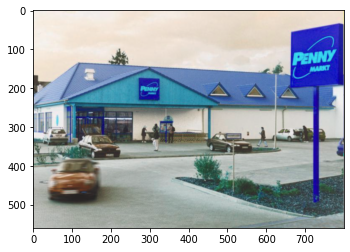

In [165]:
plt.imshow(image[0].permute((1, 2, 0)))

In [166]:
%%time
# output = model(image)
encoding_img = encoder(image)

CPU times: user 6.64 s, sys: 1.21 s, total: 7.85 s
Wall time: 8.03 s


In [167]:
%%time
decoding_img = decoder(encoding_img, segSize=size)

CPU times: user 2.9 s, sys: 486 ms, total: 3.39 s
Wall time: 4.19 s


In [168]:
output = decoding_img

In [169]:
output.shape

torch.Size([1, 150, 560, 800])

In [170]:
colors = scipy.io.loadmat('color150.mat')['colors']

(560, 800)


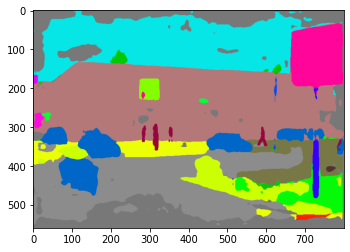

In [171]:
final = output[0].detach().numpy()
classes = np.argmax(final, axis=0)
print(classes.shape)
mask = colors[classes]
# colors = np.random.randint(0, 255, size=(150, 3))
plt.imshow(mask)